### Bike racing analysis

#### Racing: UpHill (Tangará da Serra, MT, Brazil)

Data obtained from strava for the years of 2017, 2018 and 2019.

In [1]:
import pandas as pd
import numpy as np
import lxml
import html5lib
import os
import glob
import matplotlib

#### 1. Data importing

In [2]:
# All html files at once
path = r'C:\Users\carol\Documents\DATA SCIENCE\PYTHON\PROJECTS\strava_project' 
all_files = glob.glob(os.path.join(path, "*.html"))

In [3]:
# check if all files are in
#all_files

In [4]:
# put all together
all_tables = pd.concat([pd.concat(pd.read_html(f), axis=0) for f in all_files], axis=0)

In [5]:
# all_tables
# Obs: first columns (0-3) refer to the first small table in the page - we'll use just the second
# I'm interest staring at column 4 ("Classificação")

#### 2. Data wrangling

In [6]:
# type(all_tables)

In [7]:
# delete columns from first table
all_tables.drop([0,1,2,3], axis=1, inplace=True)

In [8]:
# delete lines that have no Date ("Data") - probably not real values
all_tables = all_tables[pd.notnull(all_tables['Data'])]

In [9]:
# check
#all_tables

In [10]:
# continuing data frame wrangling
# create year column ("Ano") and put into pd date format

In [11]:
# create condition and choices for the year column based on column Data
ano_cond = [
    (all_tables['Data'].str.contains('2019', regex=True)),
    (all_tables['Data'].str.contains('2018', regex=True)),
    (all_tables['Data'].str.contains('2017', regex=True))]

choices = [2019, 2018, 2017]

In [12]:
# Now, multiple code chunks with warnings:
# warning that pandas doesn't know if you really know what are you doing (working on copy x working on view).
# the warning can be supressed:
pd.options.mode.chained_assignment = None 

all_tables['Ano'] = np.select(ano_cond, choices)

In [13]:
# transform Ano column into pd date format:
temp2 = pd.to_datetime(all_tables['Ano'], format='%Y')
all_tables['Ano'] = temp2

In [14]:
#all_tables

In [15]:
# Cols FC (cardiac frequency), Potência (power), Tempo (time to finish) and Velocidade (Speed)
# not yet recgonized as numbers

# Separate digit from letters

# Create column of time in seconds
all_tables['Tempo_sec'] = pd.to_timedelta(all_tables['Tempo']).dt.seconds

In [16]:
# FC:
all_tables['Freq_cd'] = all_tables['FC'].str.extract(pat = '([\d]*[.]?)') 

# [\d] - digits
# [\d]* - repeated 0 or more times
# [.]? - followed by optional (?) dot

In [17]:
# Potência 
all_tables['Pot'] = all_tables['Potência'].str.extract(pat = '([\d]*[.]?)') 

In [18]:
# Velocidade
all_tables['Veloc'] = all_tables['Velocidade'].str.extract(pat = '([\d]*[,]?[\d])') 

In [19]:
# Velocidade has numbers using ',' as decimal sep
all_tables['Veloc'] = [x.replace(',', '.') for x in all_tables['Veloc']]

In [20]:
# Fill with NaN before put into float/int
all_tables.replace('', np.nan, inplace=True)

In [21]:
# Freq_cd, Pot columns as floats:
all_tables['Freq_cd'] = all_tables['Freq_cd'].astype(float)
all_tables['Pot'] = all_tables['Pot'].astype(float)
all_tables['Veloc'] = all_tables['Veloc'].astype(float)

In [22]:
#all_tables # check new columns

In [23]:
# there is one observation that is probably wrong: 20 hours to finish the race,
# the person probably forgot to turn off the gps: bad data
# so, I'll drop this specific row:

i = all_tables[((all_tables.Nome == 'Jose Adolfo Correa') & (all_tables.Tempo_sec == 74669))].index
all_tables.drop(i, inplace=True)

In [24]:
# check col types
all_tables.dtypes

Classificação           float64
Data                     object
FC                       object
Nome                     object
Potência                 object
Tempo                    object
VAM                      object
Velocidade               object
Ano              datetime64[ns]
Tempo_sec                 int64
Freq_cd                 float64
Pot                     float64
Veloc                   float64
dtype: object

In [25]:
# columns that I'm interested:
table = all_tables.drop(['Data', 'FC', 'Potência', 'Tempo', 'Velocidade', 'Nome', 'VAM'], axis=1)

In [26]:
# Separate by years: I'm also going to check for differences among years:

In [27]:
# Make a mask
mask_2019 = (table['Ano'] == '2019')
mask_2018 = (table['Ano'] == '2018')
mask_2017 = (table['Ano'] == '2017')

In [28]:
table_2019 = table.loc[mask_2019]
table_2018 = table.loc[mask_2018]
table_2017 = table.loc[mask_2017]

In [29]:
# Quantity of observations: 2019>2018>2017
# len(table.index)

In [30]:
#len(table_2019.index)

In [31]:
#len(table_2018.index)

In [32]:
#len(table_2017.index)

#### 3. Exploratory Data Analysis

In [33]:
# 3.1 Summary statistics

# general - all years (groups) together and variables
table.describe()

,Classificação,Tempo_sec,Freq_cd,Pot,Veloc
count,171.000000,172.000000,53.000000,149.000000,172.000000
mean,90.894737,6501.831395,168.377358,181.161074,20.594767
std,51.569263,1689.876915,16.225842,79.454310,4.429002
min,2.000000,4510.000000,110.000000,19.000000,11.200000
25%,46.000000,5248.750000,162.000000,124.000000,17.300000
50%,91.000000,5932.500000,174.000000,166.000000,21.350000
75%,135.000000,7341.000000,177.000000,222.000000,24.125000
max,179.000000,11348.000000,192.000000,499.000000,28.100000


In [34]:
# Group by year - all variables
# too much data here to see it properly
table.groupby('Ano').describe()

Classificação                                                      \
                   count        mean        std   min     25%    50%     75%   
Ano                                                                            
2017-01-01          19.0  134.210526  35.650431  65.0  105.00  144.0  164.50   
2018-01-01          54.0   92.685185  52.578001   7.0   48.00   95.0  136.75   
2019-01-01          98.0   81.510204  49.559970   2.0   38.25   75.5  118.75   

                  Tempo_sec               ...     Pot        Veloc             \
              max     count         mean  ...     75%    max count       mean   
Ano                                       ...                                   
2017-01-01  177.0      19.0  8008.105263  ...  177.75  250.0  19.0  16.710526   
2018-01-01  178.0      54.0  6586.333333  ...  250.00  499.0  54.0  20.366667   
2019-01-01  179.0      99.0  6166.656566  ...  236.00  401.0  99.0  21.464646   

                                                         
                 std   min     25%    50%     75%   max  
Ano                                                      
2017-01-01  3.913778  11.3  14.000  16.30  19.900  23.3  
2018-01-01  4.461661  11.3  17.175  20.85  24.025  27.0  
2019-01-01  4.114690  11.2  18.750  22.50  24.600  28.1  

[3 rows x 40 columns]

In [35]:
# Summary of each variable, more organized:
# Most interesting variables: Tempo_sec, Veloc, Freq_cd, Pot

In [36]:
table.groupby('Ano')['Tempo_sec'].describe()
# suggests: average time to finish race (and its sd and minimum) decreased through years

,count,mean,std,min,25%,50%,75%,max
Ano,,,,,,,,
2017-01-01,19.0,8008.105263,1980.242098,5434.0,6359.0,7771.0,9034.00,11164.0
2018-01-01,54.0,6586.333333,1750.428745,4685.0,5279.5,6084.5,7370.25,11173.0
2019-01-01,99.0,6166.656566,1431.174907,4510.0,5148.5,5628.0,6747.00,11348.0


In [37]:
table.groupby('Ano')['Veloc'].describe()
# suggests: avg speed race (and its max and sd) increased through years

,count,mean,std,min,25%,50%,75%,max
Ano,,,,,,,,
2017-01-01,19.0,16.710526,3.913778,11.3,14.000,16.30,19.900,23.3
2018-01-01,54.0,20.366667,4.461661,11.3,17.175,20.85,24.025,27.0
2019-01-01,99.0,21.464646,4.114690,11.2,18.750,22.50,24.600,28.1


In [38]:
table.groupby('Ano')['Freq_cd'].describe()
# suggests: avg did not change much

,count,mean,std,min,25%,50%,75%,max
Ano,,,,,,,,
2017-01-01,9.0,165.000000,16.500000,130.0,158.00,168.0,174.00,187.0
2018-01-01,14.0,169.071429,17.551964,119.0,166.75,174.5,177.75,190.0
2019-01-01,30.0,169.066667,15.956694,110.0,162.00,175.0,177.00,192.0


In [39]:
table.groupby('Ano')['Pot'].describe()
# no visible trend

,count,mean,std,min,25%,50%,75%,max
Ano,,,,,,,,
2017-01-01,18.0,140.944444,53.267883,83.0,100.25,122.0,177.75,250.0
2018-01-01,46.0,190.347826,86.838859,19.0,136.00,175.5,250.00,499.0
2019-01-01,85.0,184.705882,78.123654,45.0,124.00,167.0,236.00,401.0


In [40]:
# also check median
table.groupby('Ano').median()

,Classificação,Tempo_sec,Freq_cd,Pot,Veloc
Ano,,,,,
2017-01-01,144.0,7771.0,168.0,122.0,16.30
2018-01-01,95.0,6084.5,174.5,175.5,20.85
2019-01-01,75.5,5628.0,175.0,167.0,22.50


In [41]:
# Apparently, across the years, average (and median) total time to finish the race (Tempo_sec) has decreased,
# while average Velocity (Veloc) has increased,
# Although we have more data from 2019 than compared to 2017

In [42]:
# 3.2Plotting 

In [43]:
%matplotlib inline
import seaborn as sns

In [44]:
# check the distribution of the variables
# I won't make any assumptions on what type of these sample distributions are more closely related

In [45]:
sns.set(color_codes=True)

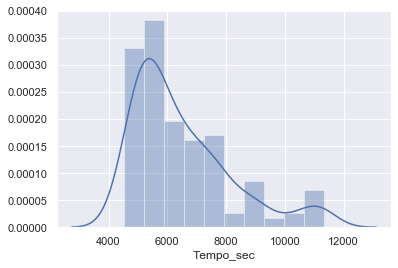

In [46]:
# Tempo_sec
x = table['Tempo_sec']
sns.distplot(x);

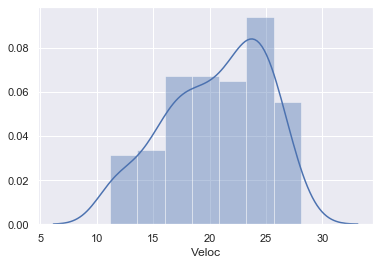

In [47]:
# Veloc:
x = table['Veloc']
sns.distplot(x);

In [48]:
# Relationship between variables

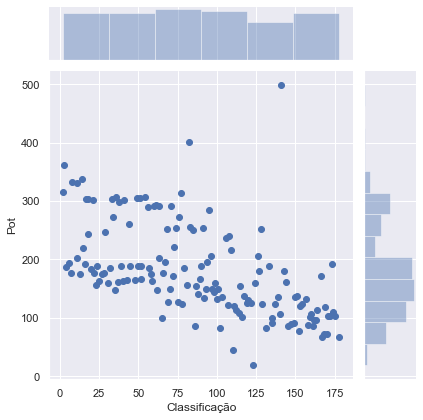

In [49]:
# Classificação (classification) x pot
sns.jointplot(x ='Classificação', y ='Pot', data = table) 

# (weak negative linear relationship)

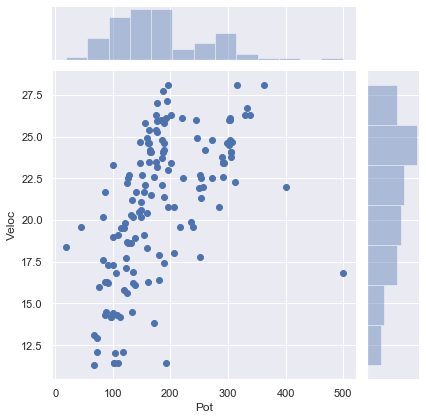

In [50]:
# Velocity x pot
sns.jointplot(x ='Pot', y ='Veloc', data = table) 

# (weak positive linear relationship)

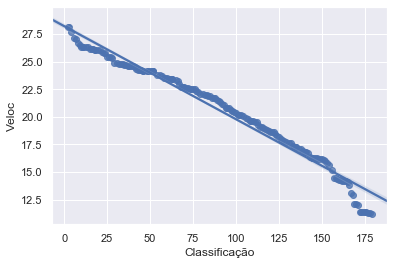

In [51]:
# Velocity x Classificação

sns.regplot(x="Classificação", y="Veloc", data=table)
# an almost (obvious?) strong negative linear relationship:
# the > the average speed during the whole racing, the higher the classification

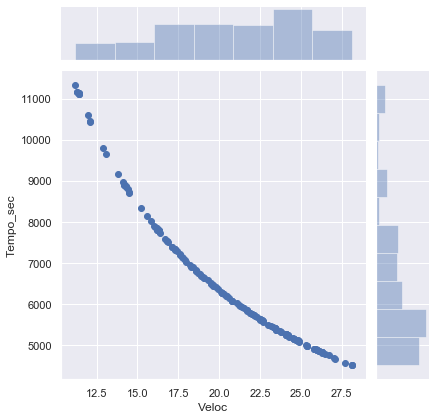

In [52]:
# Tempo_sec x Veloc
# (probably obvious)
sns.jointplot(x ='Veloc', y ='Tempo_sec', data = table) 

# strong (not linear) relationship

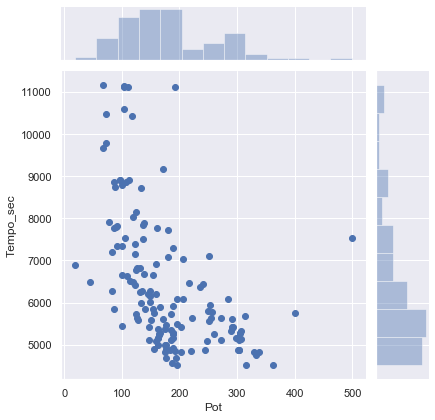

In [53]:
# Tempo_sec x pot
sns.jointplot(x ='Pot', y ='Tempo_sec', data = table) 

# does not have an obvious trend: weak negative linear relationship
# and suggests that there's a optimum pot to achieve lowest times

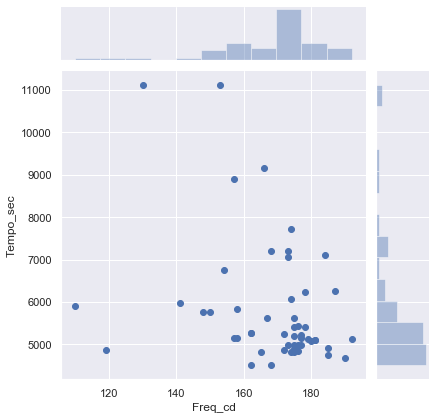

In [54]:
# Freq_cd x Tempo_sec
sns.jointplot(x ='Freq_cd', y ='Tempo_sec', data = table) 

# no trend
# Mostly, the lowest times were achieved by higher cardiac frequency
# although few points indicate lower frequency and also lower times....

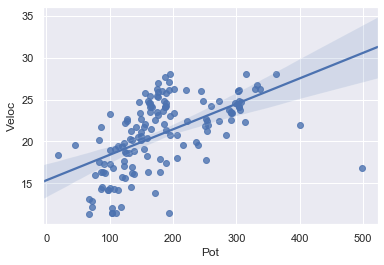

In [55]:
# Fitting regression line: pot x velocity
sns.regplot(x="Pot", y="Veloc", data=table)

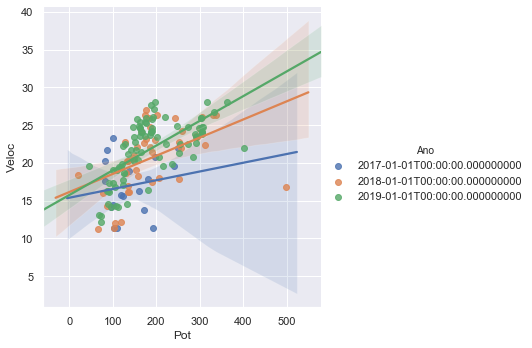

In [56]:
# Groupping by years
# Pot x Veloc
sns.lmplot(x="Pot", y="Veloc", hue="Ano", data=table);

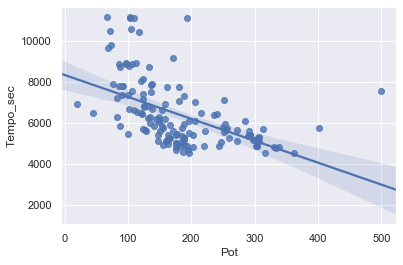

In [57]:
# pot x tempo_sec
sns.regplot(x="Pot", y="Tempo_sec", data=table)

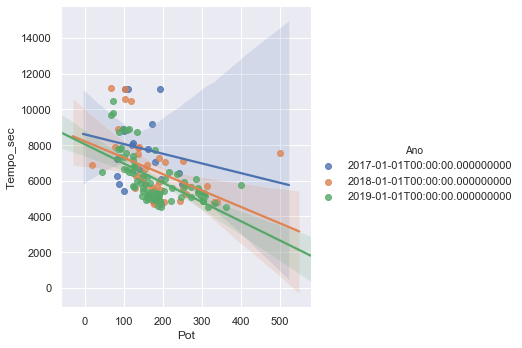

In [58]:
# pot x tempo_sec by year
sns.lmplot(x="Pot", y="Tempo_sec", hue="Ano", data=table)

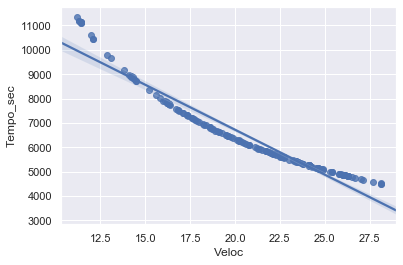

In [59]:
# Veloc x Tempo_sec
sns.regplot(x="Veloc", y="Tempo_sec", data=table)

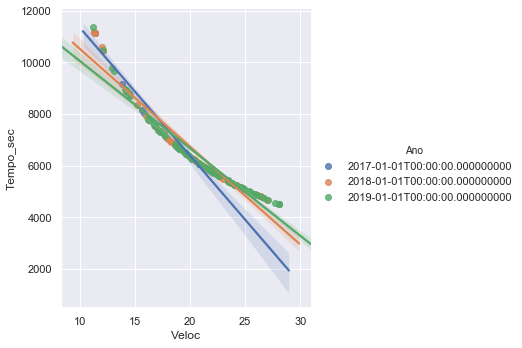

In [60]:
# Veloc x Tempo_sec by years
sns.lmplot(x="Veloc", y="Tempo_sec", hue="Ano", data=table);

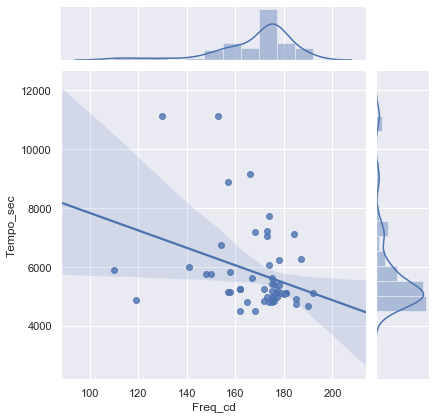

In [61]:
# Freq_cd x Tempo_sec
sns.jointplot(x="Freq_cd", y="Tempo_sec", data=table, kind="reg");

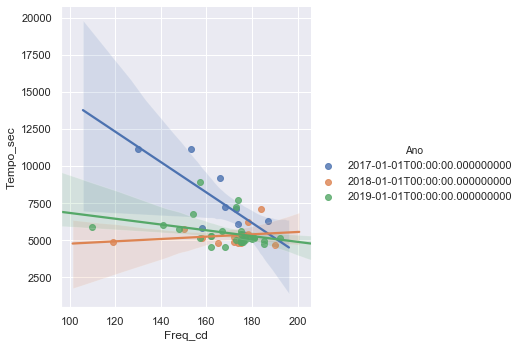

In [62]:
# Freq_cd x Tempo_sec by years
sns.lmplot(x="Freq_cd", y="Tempo_sec", hue="Ano", data=table);

In [63]:
# check skewness
table.skew()

# (Between -05. and 0.5 would be approximately symmetric) 

Classificação   -0.001246
Tempo_sec        1.271787
Freq_cd         -1.712853
Pot              0.873612
Veloc           -0.422927
dtype: float64

In [64]:
# check kurtosis
table.kurtosis()

Classificação   -1.202462
Tempo_sec        1.035608
Freq_cd          3.589134
Pot              0.920572
Veloc           -0.763023
dtype: float64

In [65]:
# Vartiable of most interest: Veloc and Time_sec may have differences among years: 
# 2019 with the highest and lowest, respec.

# Freq_cd and Pot do not present an obvious trend or relationship,
# and they may have an 'optimum' point to provide the lowest times to finish the race

#### 4. Statistical analysis

In [66]:
# Analyze if variables of interest differ among groups (years)
# Does the performance of this racing is increasing?

# Not assuming normal distribution (EDA): Opting for a non-parametric test
# Null hypothesis: the median between samples do not differ

In [67]:
from scipy import stats

In [68]:
stats.kruskal(table_2019['Tempo_sec'],table_2018['Tempo_sec'],table_2017['Tempo_sec'], nan_policy='omit')

KruskalResult(statistic=17.12367559403214, pvalue=0.00019126745967311764)

In [69]:
stats.kruskal(table_2019['Veloc'],table_2018['Veloc'],table_2017['Veloc'], nan_policy='omit')

KruskalResult(statistic=17.4198369853204, pvalue=0.00016494169788441756)

In [70]:
stats.kruskal(table_2019['Pot'],table_2018['Pot'],table_2017['Pot'], nan_policy='omit')

KruskalResult(statistic=6.082005810761336, pvalue=0.04778693967472602)

In [71]:
stats.kruskal(table_2019['Freq_cd'],table_2018['Freq_cd'],table_2017['Freq_cd'], nan_policy='omit')

KruskalResult(statistic=1.1929473238805723, pvalue=0.5507503477212985)

In [72]:
# The test suggests that we reject the null hypothesis that all meadians are equal
# Proceed with a posthoc non-parametric test to determine what groups (years) differ
# (for the variables of most interest that were rejected in the Kruskal-Wallis: Tempo_sec and Veloc)

In [73]:
import scikit_posthocs as sp

In [74]:
# Tempo_sec in years
sp.posthoc_conover(table, val_col='Tempo_sec', group_col='Ano', p_adjust = 'holm')

,2017-01-01,2018-01-01,2019-01-01
2017-01-01,-1.000000,0.003939,0.000081
2018-01-01,0.003939,-1.000000,0.153512
2019-01-01,0.000081,0.153512,-1.000000


In [75]:
# Veloc in years
sp.posthoc_conover(table, val_col='Veloc', group_col='Ano', p_adjust = 'holm')

,2017-01-01,2018-01-01,2019-01-01
2017-01-01,-1.000000,0.003422,0.000068
2018-01-01,0.003422,-1.000000,0.154768
2019-01-01,0.000068,0.154768,-1.000000


In [76]:
# (considering the groups as each of the years of 2017, 2018 and 2019, that here appears as the whole date)
# The total time to finish the race was different between pairs, except between 2018-2019
# The same result found for Velocity during the race

#### 5. Conclusion

+ Although there were some differences of total time to finish the race, we cannot conclude that the performance of the racing is increasing across the assessed years

+ 2018 and 2019 were superior to 2017 (total time and velocity), but no differences between 2018-2019